## Inventory Dynamics

#### John Stachurski

Prepared for the Shenzhen Winter Camp

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Part 1: Sample Paths and Joint Distributions

Consider a firm with inventory $X_t$

Wait till $X_t \leq s$, then order $S$ units

Firm faces stochastic demand $D_{t+1}$, where $\{D_t\}$ is independent with common distribution $\phi$

Inventory follows


\begin{equation*}
  X_{t+1} = 
  \begin{cases}
      ( S - D_{t+1})^+ & \quad \text{if } X_t \leq s \\
      ( X_t - D_{t+1} )^+ &  \quad \text{if } X_t > s
  \end{cases}
\end{equation*}


Here $a^+ := \max\{a, 0\}$

We'll assume that $\phi$ is the geometric distribution, so that

$$ \mathbb P \{D_t = d\} = (1 - p)^d p $$

for $d = 0, 1, \ldots$.  Here $p$ is a parameter in $(0, 1)$.

In [2]:
s, S = 10, 100
p = 0.4

def ϕ():
    return np.random.geometric(p) - 1

def G(x, d):
    if x <= s:
        return max(S - d, 0)
    else:
        return max(x - d, 0)
    

A first simulation:

In [3]:
sim_length = 100
X = np.empty(sim_length)
X[0] = 50

for t in range(sim_length-1):
    D = ϕ()
    X[t+1] = G(X[t], D)

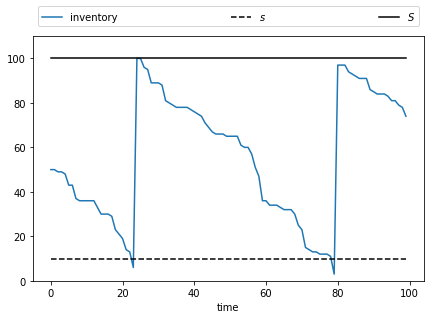

In [4]:
fig, ax = plt.subplots(figsize=(7, 4.5))
bbox = (0., 1.02, 1., .102)
legend_args = {'ncol': 3,
               'bbox_to_anchor': bbox,
               'loc': 3,
               'mode': 'expand'}

ax.plot(X, label="inventory")
ax.plot(s * np.ones(sim_length), 'k--', label="$s$")
ax.plot(S * np.ones(sim_length), 'k-', label="$S$")
ax.set_ylim(0, S+10)
ax.set_xlabel("time")
ax.legend(**legend_args)

plt.show()

Let's make a function for simulating paths

In [5]:
def sim_inventory_paths(initial_x=50, sim_length=100):
    X = np.empty(sim_length)
    X[0] = 50

    for t in range(sim_length-1):
        D = ϕ()
        X[t+1] = G(X[t], D)
    
    return X

Simulate multiple paths:

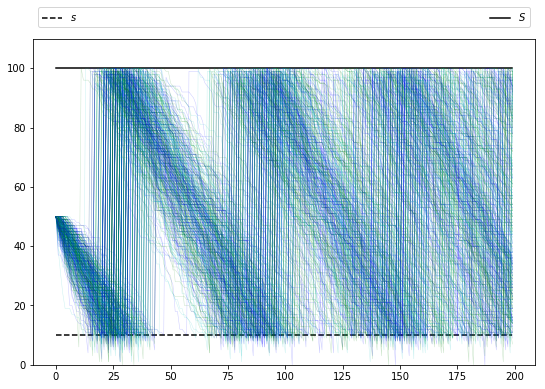

In [6]:
sim_length=200
fig, ax = plt.subplots(figsize=(9, 6))
bbox = (0., 1.02, 1., .102)
legend_args = {'ncol': 3,
               'bbox_to_anchor': bbox,
               'loc': 3,
               'mode': 'expand'}

ax.plot(s * np.ones(sim_length), 'k--', label="$s$")
ax.plot(S * np.ones(sim_length), 'k-', label="$S$")
ax.set_ylim(0, S+10)
ax.legend(**legend_args)

for i in range(400):
    rcolor = random.choice(('c', 'g', 'b'))
    X = sim_inventory_paths(sim_length=sim_length)
    ax.plot(X, color=rcolor, alpha=0.2, lw=0.5)

plt.show()

What's the probability that we need to order twice or more in the first 50 periods?

In [7]:
sim_length = 50
M = 100000  
counter = 0

for m in range(M):
    X = sim_inventory_paths(sim_length=50)
    if sum(X <= s) > 1:
        counter += 1
        
print(f"Frequency of at least two stock outs = {counter / M}")

Frequency of at least two stock outs = 8e-05


### Part 2: Marginal Distributions

Now let's look at the marginal distribution $\psi_T$ for some fixed $T$.

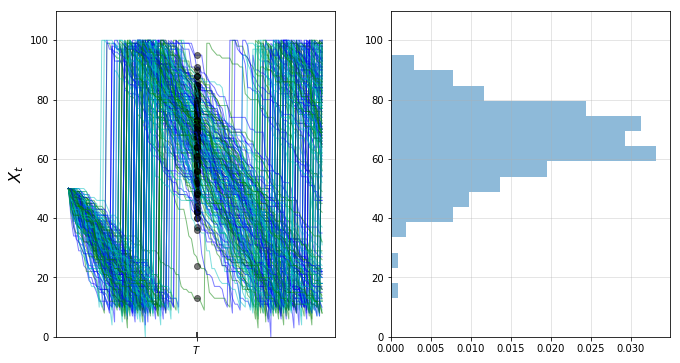

In [8]:
T = 50
M = 200

ymin, ymax = 0, S + 10

fig, axes = plt.subplots(1, 2, figsize=(11, 6))

for ax in axes:
    ax.grid(alpha=0.4)

ax = axes[0]

ax.set_ylim(ymin, ymax)
ax.set_ylabel('$X_t$', fontsize=16)
ax.vlines((T,), -1.5, 1.5)

ax.set_xticks((T,))
ax.set_xticklabels((r'$T$',))

sample = np.empty(M)
for m in range(M):
    rcolor = random.choice(('c', 'g', 'b'))
    X = sim_inventory_paths(sim_length=2 * T)
    ax.plot(X, color=rcolor, lw=1, alpha=0.5)
    ax.plot((T,), (X[T+1],), 'ko', alpha=0.5)
    sample[m] = X[T+1]

axes[1].set_ylim(ymin, ymax)

axes[1].hist(sample, 
             bins=16, 
             density=True, 
             orientation='horizontal', 
             histtype='bar',
             alpha=0.5)

plt.show()

We can build up a clearer picture by drawing more samples

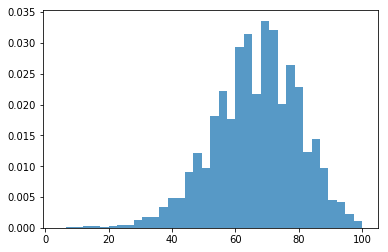

In [9]:
T = 50
M = 50000

fig, ax = plt.subplots()

sample = np.empty(M)
for m in range(M):
    X = sim_inventory_paths(sim_length=T+1)
    sample[m] = X[T]

ax.hist(sample, 
         bins=36, 
         density=True, 
         histtype='bar',
         alpha=0.75)

plt.show()

We can also approximate the distribution using a kernel density estimator.  I'll use one from Scikit Learn.



In [10]:
from sklearn.neighbors import KernelDensity

def plot_kde(sample, ax, label=''):
    
    xmin, xmax = 0.9 * min(sample), 1.1 * max(sample)
    xgrid = np.linspace(xmin, xmax, 200)
    kde = KernelDensity(kernel='gaussian').fit(sample[:, None])
    log_dens = kde.score_samples(xgrid[:, None])

    ax.plot(xgrid, np.exp(log_dens), label=label)

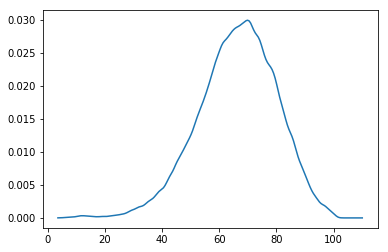

In [11]:
fig, ax = plt.subplots()
plot_kde(sample, ax)
plt.show()

In general, marginal distributions change over time.  Let's look at what happens if we run time forwards and plot some of the marginal distributions.

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

M = 5000  # Number of paths
T = 50
X = np.empty((M, T))

for m in range(M):
    X[m, :] = sim_inventory_paths(sim_length=T)

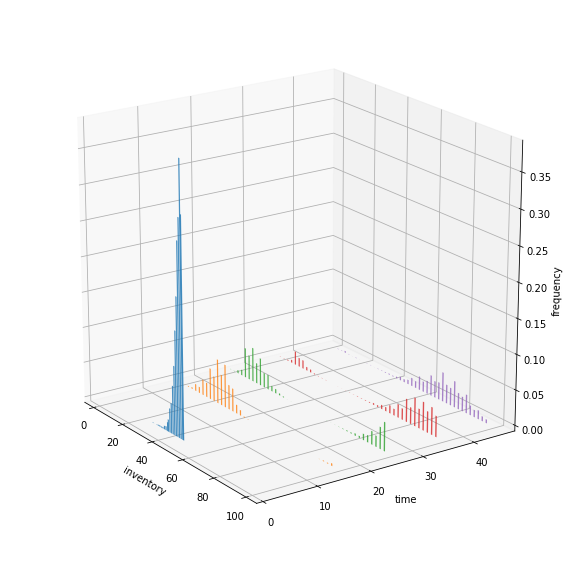

In [13]:
sample_dates = 2, 15, 25, 35, 45
nbins = 40

for t in sample_dates:

    hist, bins = np.histogram(X[:, t], bins=nbins, normed=True)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=t, zdir='y', alpha=0.8)

ax.set_xlabel('inventory')
ax.set_ylabel('time')
ax.set_zlabel('frequency')
ax.view_init(elev=20., azim=-35)
plt.show()

### Part 3: Asymptotic Stationarity and Ergodicity

This model is asymptotically stationary, with a unique stationary distribution.  We can see convergence to the sationary distribution in the figures below.

In [14]:
M = 5000  # Number of paths
T = 501
X = np.empty((M, T))

for m in range(M):
    X[m, :] = sim_inventory_paths(sim_length=T)

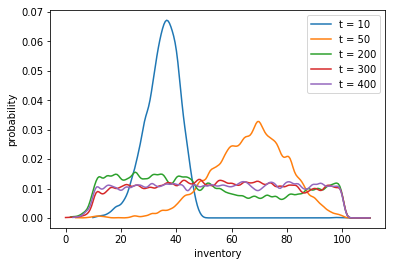

In [15]:
fig, ax = plt.subplots()
sample_dates = 10, 50, 200, 300, 400

for t in sample_dates:
    plot_kde(X[:, t], ax, label=f't = {t}')

ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

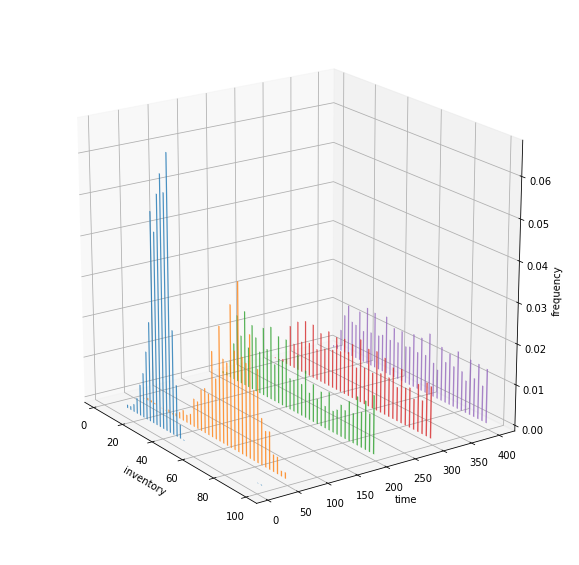

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for t in sample_dates:

    hist, bins = np.histogram(X[:, t], bins=nbins, normed=True)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=t, zdir='y', alpha=0.8)

ax.set_xlabel('inventory')
ax.set_ylabel('time')
ax.set_zlabel('frequency')
ax.view_init(elev=20., azim=-35)
plt.show()

Let's say we want to compute the mean of the stationary distribution, which gives average inventory over the long run.  We can easily do this by simulation, using ergodicity:

In [17]:
X = sim_inventory_paths(sim_length=10000)
print(X.mean())

54.8149
